In [1]:
# R-cnn
# 영역분할이란
# 객체의 바운딩 박스 뿐만 아니라 픽셀 단위 클래그 분류까지 -> 객체의 윤곽 구분
# semantic segmentation : 하나의 클래스는 모두 같은 레이블
# instance segmentation : 객체 단위 다른 레이블

# RCNN
# Mask-RCNN이란?
# 대표적인 객체 영역 분할 딥러닝 알고리즘
# faster R-CNN(object detection) + FCN(segmantic segmentation )
# faster R-CNN에서 빠르게 객체 detection을 한 뒤 detection한 객체에 세분화 작업

# 모델 파일 : http://download.tensorflow.org/models/object_detection/ mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
# config : https://github.com/opencv/opencv_extra/blob/4.x/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
# 모델 및 config 다운로드 사이트 : https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

In [44]:
import cv2
import numpy as np
import sys
from PIL import Image

def drawBox(img, classId, conf, left, top, right, bottom):
    # Draw rectangle bounding box
    cv2.rectangle(img, (left, top), (right, bottom), colors[classId], 2)
    
    label = f'{classes[classId]}: {conf:.2f}'
    
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(img, (left - 1, top - labelSize[1] - baseLine),(left + labelSize[0], top), colors[classId], -1)
    cv2.putText(img, label, (left, top - baseLine), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 0), 1, cv2.LINE_AA)

# 추론
# 모델 & 설정파일
model = '/Users/jungjihoon/Desktop/rcnn/test/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
config = '/Users/jungjihoon/Desktop/rcnn/test/graph.pbtxt' # config 파일을 다운 받은 후 graph.pbtxt로 이름을 바꾸어주어야한다.
class_labels = '/Users/jungjihoon/Desktop/rcnn/coco_90.names.txt'
confThreshold = 0.6
maskThreshold = 0.3 


# 이미지 불러오기
dog = "/Users/jungjihoon/Desktop/rcnn/dog.jpg"
traffic = "/Users/jungjihoon/Desktop/rcnn/traffic.jpg"
sheep = "/Users/jungjihoon/Desktop/rcnn/sheep.jpg"
img_files = [dog, traffic, sheep]

# 네트워크 생성
net = cv2.dnn.readNet(model, config)

if net.empty():
    print("net read failed")
    sys.exit()
    
# 클래스 이름 불러오기
classes = []
with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
    
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# 전체 레이어 이름 받아오기
layer_names = net.getLayerNames() #네트워크의 모든 레이어 이름 가져오기
# net.getUnconnectedOutLayers(): 출력 레이어의 인덱스를 가져오기(인덱스는 332)
# output_layers: detection_masks 1개(출력레이어)
# 위 내용을 가지고 생각해 보면 네트워크 layer 중에서 마지막 출력 레이어는 네트워크 레이어에 포함되지 않는다는 걸로 연결됨
# 레이어 종류가 네트워크 레이어, 출력 레이어 이렇게 두개로 나뉜걸로 생각할수 있음
# layer_names
# FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d/depthwise
# FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d
# FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/BatchNorm/FusedBatchNorm
# FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/Relu
# FirstStageFeatureExtractor/InceptionV2/InceptionV2/MaxPool_2a_3x3/MaxPool
# ...

output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# output_layers : 'detection_masks'

imgs = []

for f in img_files:
    img = cv2.imread(f)
    
    if img is None:
        continue
        
    # 블롭생성
    # blob의 사이즈는 지정 안해도 됨. -> 이미지 크기와 동일한 크기로 만들어줌
    # 평균값 디폴트는 0이므로 여기서는 따로 지정 안함
    blob = cv2.dnn.blobFromImage(img, swapRB=True) # RGB로 학습되어있음
    net.setInput(blob)
    # detection_out_final: 바운딩박스 정보
    # detection_masks: 각각의 바운딩 박스에서 마스크 정보를 가지고 있음
    # 큰 순서: 각 객체의 바운딩박스 정보를 추출한 후에 그 박스 안에 있는 객체윤곽를 추출
    
    boxes, masks = net.forward(['detection_out_final', 'detection_masks'])
    # boxes.shape =  (1, 1, 100, 7) ==> 최개 100개까지 객체 검출이 가능하며, 7은 클래스 정보 또는 바운딩의 정보이다. 7개의 정보 : [0, classId, conf, x1, y1, x2, y2 ]
    # masks.shape =  (100, 90, 15, 15) ==> 각각의 100개 객체에 대해서 90개의 마스크맵을 출력으로 준다. 그리고 90개의 class에 대한 15*15마스크가 출력된다.
        
    # classID: 몇번째에 대한 바운딩 박스 인가를 나타냄
    # confidence: 확률값(임계값보다 커야 제대로 찾았다고 인식한다)
    # 입력영상의 크기가 0~1 정규화가 되었다는 가정 하에 x1,y1:좌측상단 , x2,y2:우측하단
    # box: (0,classID,confidence, x1,y1,x2,y2) -> (7,)

    # 100개의 객체 검출한것에 대해서 15*15 마스크 맵이 90개가 있는 것
    # 90개 마스크를 다 쓰는게 아니라 94번줄의 ClassId에 해당하는 것만 사용 
    
    h, w = img.shape[:2]
    numClasses = masks.shape[1] # 90(coco dataset의 클래스 개수)
    numDetections = boxes.shape[2] # 100 (detection의 개수, 100개가 최대이며 이보다 낮게 나올수도있음)
    
    boxesToDraw = []
    for i in range(numDetections):
        box = boxes[0,0,i] # 100개의 객체의 바운딩 박스 7개의 정보를 가져온다 box.shape = (7,) [0, classId, conf, x1, y1, x2, y2 ]
        mask = masks[i] # 15*15크기 마스크 90개를 가져온다 mask.shape=(90, 15, 15)
        score = box[2] # conf (confidences) 확률값 [0, classId, *conf, x1, y1, x2, y2 ]
        if score > confThreshold: # 해당 임계값보다 높은 confidences만 뽑는다.
            classId = int(box[1]) # classId
            
            # 변환된 좌표
            x1 = int(w * box[3])
            y1 = int(h * box[4])
            x2 = int(w * box[5])
            y2 = int(h * box[6])
            
            # 변환된 좌표와 원래 img크기를 비교해서
            # 변환된 자표가 본 이미지 크기보다 큰 경우를 없애기 위한 코드
            x1 = max(0, min(x1, w - 1))
            y1 = max(0, min(y1, h - 1))
            x2 = max(0, min(x2, w - 1))
            y2 = max(0, min(y2, h - 1))
            
            boxesToDraw.append([img, classId, score, x1, y1, x2, y2])
            
            # classMask : 15*15짜리 행렬의 float형태의 마스크
            # 이 안에서 배경에 해당하는 부분은 값이 작을것이고, 객체에 해당하는 건 값이 크다
            classMask = mask[classId]
            
            # 객체별 15*15 마스크를 바운딩 박스 크기를 resize한 후, 불투명 컬러로 표시
            classMask = cv2.resize(classMask, (x2 - x1 + 1, y2 - y1 + 1))
            # 바운딩박스 안에는 배경과 객체가 있는데, 어떤한 기준값이 있어야 객체와 배경을 구분할 수가 있다.
            # 이 구분하기 위한 기준값이 maskThreshold보다 크면 객체 아니면 배경
            mask = (classMask > maskThreshold)
            
            # 객체마다 다른 색깔 불투명하게 하는 코드 -> 결과영상에서 클래스 윤곽정보를 보여줌
            roi = img[y1:y2+1, x1:x2+1][mask] # 원본 실제 객체 이미지
            img[y1:y2+1, x1:x2+1][mask] = (0.7 * colors[classId] + 0.3 * roi).astype(np.uint8)
    
    # 객체별 바운딩 박스 그리기 & 클래스 이름 표시 --> 이게 없으면 결과영상에서 바운딩 박스가 없다.
    for box in boxesToDraw:
        drawBox(*box)
        
    t, _ = net.getPerfProfile()
    label = 'inference time : %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), cv2.LINE_AA)
    
    imgs.append(img)    

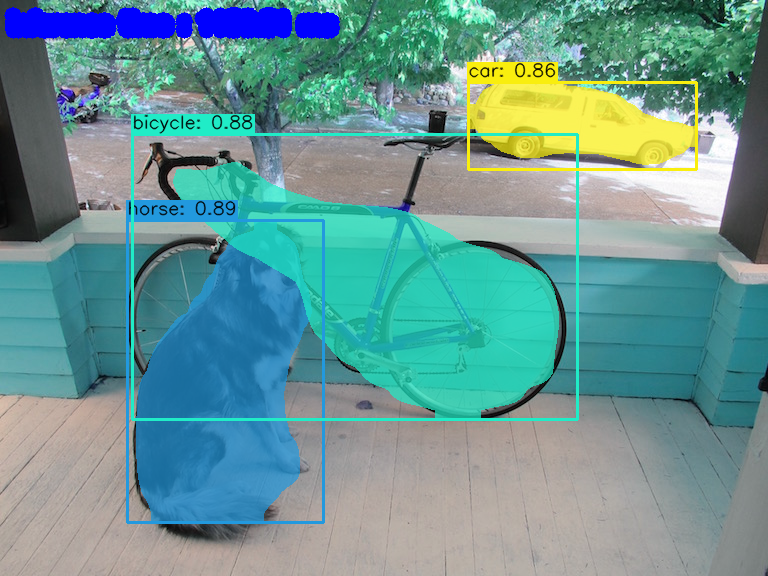

In [45]:
# dog를 horse로..?
Image.fromarray(imgs[0])

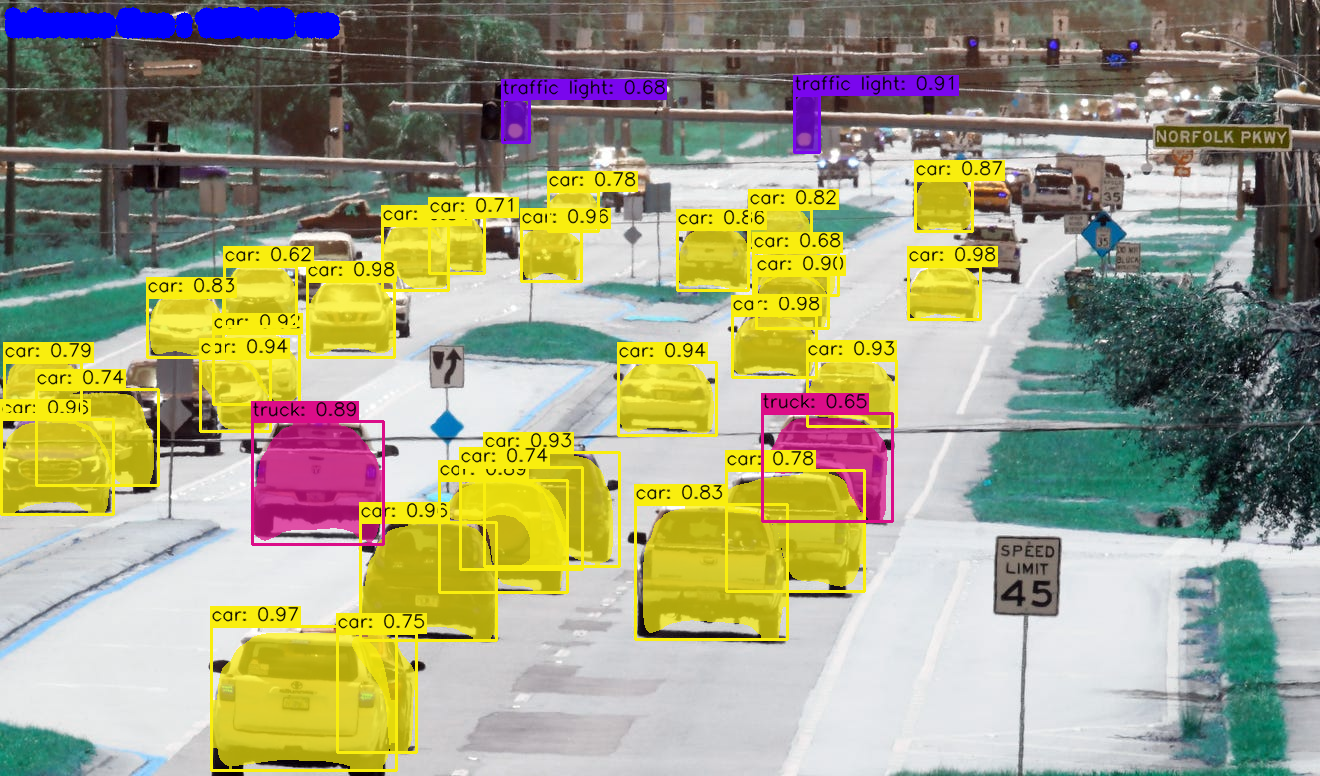

In [46]:
# 대략 잘 보여준다
Image.fromarray(imgs[1])

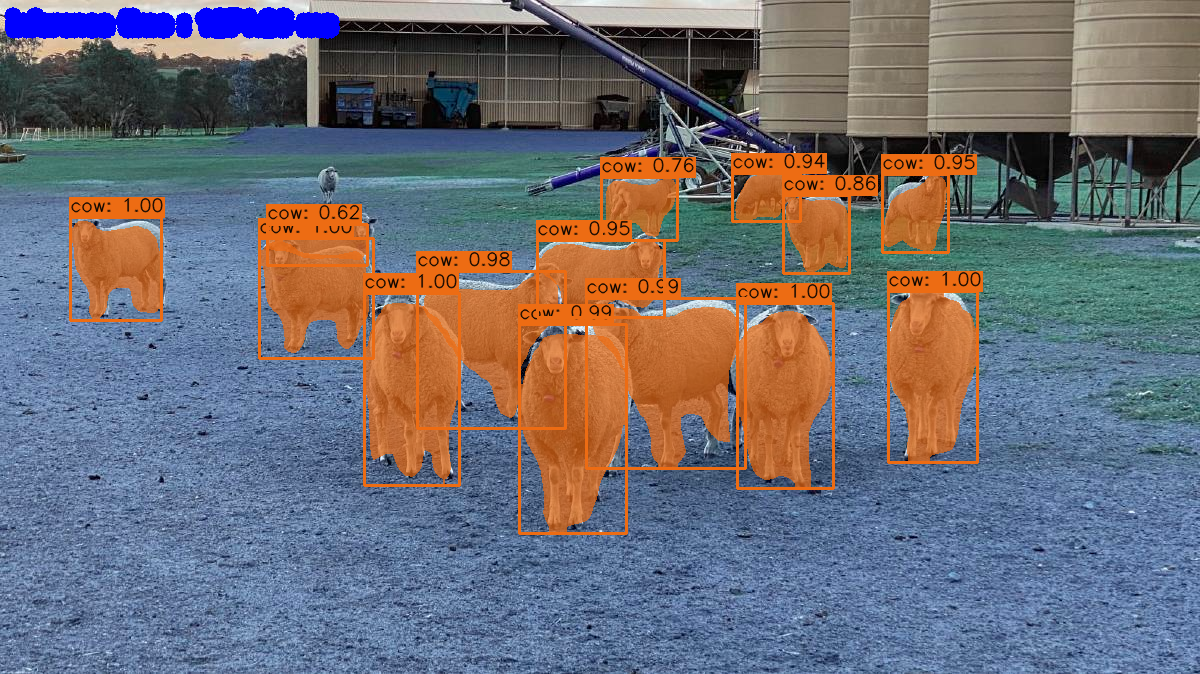

In [47]:
# sheep를 cow로..?
Image.fromarray(imgs[2])